<a href="https://colab.research.google.com/github/seankaczanowski/Code-Breaker/blob/master/NHL_Over_Under_Performers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NHL Goal Overperformance Analysis 🏒🔥
## Identifying NHL Players Who Overperform or Underperform in Goal Scoring
## Sean Kaczanowski

### 📌 Overview:
This project analyzes NHL skaters from the **2023 regular season** to determine:
- **Who is overperforming?** (Scoring more than expected)
- **Who is underperforming?** (Scoring less than expected)

I use **MoneyPuck's NHL player data**, comparing **actual goals (`I_F_goals`)** vs **expected goals (`I_F_xGoals`)** to find "hot" and "cold" players.

---


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

## 🔄 Loading the Data

In [22]:
#Load the sample nhl_players_stats.csv dataset from Google Drive

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = "/content/drive/MyDrive/NHLdata/nhl_player_stats.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,playerId,season,name,team,position,situation,games_played,icetime,shifts,gameScore,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
0,8480950,2023,Ilya Lyubushkin,TOR,D,other,74,2881.0,56.0,5.08,...,18.00,21.61,195.0,191.0,0.11,0.02,3.0,1.0,3.0,1.0
1,8480950,2023,Ilya Lyubushkin,TOR,D,all,74,76034.0,1717.0,4.47,...,176.13,171.61,3226.0,3132.0,0.00,0.00,0.0,0.0,0.0,0.0
2,8480950,2023,Ilya Lyubushkin,TOR,D,5on5,74,61758.0,1389.0,4.47,...,107.09,104.80,2302.0,2303.0,6.54,0.64,140.0,11.0,108.0,8.0
3,8480950,2023,Ilya Lyubushkin,TOR,D,4on5,74,11271.0,259.0,3.43,...,4.28,27.86,68.0,482.0,0.11,0.00,4.0,0.0,3.0,0.0
4,8480950,2023,Ilya Lyubushkin,TOR,D,5on4,74,124.0,13.0,3.45,...,6.03,1.37,106.0,19.0,0.00,0.00,0.0,0.0,0.0,0.0


In [23]:
#Data Inspection

# Display basic info about the dataset
df.info()

# Display summary statistics
df.describe()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620 entries, 0 to 4619
Columns: 154 entries, playerId to fenwickAgainstAfterShifts
dtypes: float64(147), int64(3), object(4)
memory usage: 5.4+ MB


,0
playerId,0
season,0
name,0
team,0
position,0
...,...
xGoalsAgainstAfterShifts,0
corsiForAfterShifts,0
corsiAgainstAfterShifts,0
fenwickForAfterShifts,0


In [25]:
# Display all column names
df.columns.tolist()

['playerId',
 'season',
 'name',
 'team',
 'position',
 'situation',
 'games_played',
 'icetime',
 'shifts',
 'gameScore',
 'onIce_xGoalsPercentage',
 'offIce_xGoalsPercentage',
 'onIce_corsiPercentage',
 'offIce_corsiPercentage',
 'onIce_fenwickPercentage',
 'offIce_fenwickPercentage',
 'iceTimeRank',
 'I_F_xOnGoal',
 'I_F_xGoals',
 'I_F_xRebounds',
 'I_F_xFreeze',
 'I_F_xPlayStopped',
 'I_F_xPlayContinuedInZone',
 'I_F_xPlayContinuedOutsideZone',
 'I_F_flurryAdjustedxGoals',
 'I_F_scoreVenueAdjustedxGoals',
 'I_F_flurryScoreVenueAdjustedxGoals',
 'I_F_primaryAssists',
 'I_F_secondaryAssists',
 'I_F_shotsOnGoal',
 'I_F_missedShots',
 'I_F_blockedShotAttempts',
 'I_F_shotAttempts',
 'I_F_points',
 'I_F_goals',
 'I_F_rebounds',
 'I_F_reboundGoals',
 'I_F_freeze',
 'I_F_playStopped',
 'I_F_playContinuedInZone',
 'I_F_playContinuedOutsideZone',
 'I_F_savedShotsOnGoal',
 'I_F_savedUnblockedShotAttempts',
 'penalties',
 'I_F_penalityMinutes',
 'I_F_faceOffsWon',
 'I_F_hits',
 'I_F_takeaways

In [26]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Show only columns with missing values

,0


## 🛠 Data Preparation
I filter the dataset to focus on key offensive stats:
- **Player name & team** (`name`, `team`)
- **Games played** (`games_played`)
- **Goals & expected goals** (`I_F_goals`, `I_F_xGoals`)
- **Additional stats** (`I_F_points`, `I_F_shotsOnGoal`, `gameScore`)

In [19]:
# Creating performance_df with relevant columns
performance_df = df[['name', 'team', 'position', 'games_played',
                     'I_F_goals', 'I_F_points', 'I_F_shotsOnGoal',
                     'I_F_xGoals', 'gameScore', 'onIce_xGoalsPercentage',
                     'onIce_corsiPercentage']]

# Display first few rows
performance_df.head()

,name,team,position,games_played,I_F_goals,I_F_points,I_F_shotsOnGoal,I_F_xGoals,gameScore,onIce_xGoalsPercentage,onIce_corsiPercentage
0,Ilya Lyubushkin,TOR,D,74,0.0,0.0,2.0,0.24,5.08,0.37,0.28
1,Ilya Lyubushkin,TOR,D,74,0.0,8.0,47.0,2.71,4.47,0.36,0.38
2,Ilya Lyubushkin,TOR,D,74,0.0,8.0,41.0,2.38,4.47,0.46,0.46
3,Ilya Lyubushkin,TOR,D,74,0.0,0.0,3.0,0.07,3.43,0.05,0.06
4,Ilya Lyubushkin,TOR,D,74,0.0,0.0,1.0,0.02,3.45,1.00,0.80


## 🔥 Finding Hot & Cold Players
To identify overperformers and underperformers, I calculate:
- **Goal Differential** = `Actual Goals - Expected Goals (I_F_goals - I_F_xGoals)`
- **Hot Players:** Scoring well above expected goals.
- **Cold Players:** Struggling to convert chances.


In [17]:
# Add goal differential column
performance_df['goal_diff'] = performance_df['I_F_goals'] - performance_df['I_F_xGoals']

# Identify hot and cold players
hot_players = performance_df.sort_values(by='goal_diff', ascending=False).head(10)
cold_players = performance_df.sort_values(by='goal_diff', ascending=True).head(10)

# Display results
hot_players, cold_players


<ipython-input-17-7311d8c9cd85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_df['goal_diff'] = performance_df['I_F_goals'] - performance_df['I_F_xGoals']


(                       name team position  games_played  I_F_goals  \
 2281         Artemi Panarin  NYR        L            82       49.0   
 3091        Auston Matthews  TOR        C            81       69.0   
 2282         Artemi Panarin  NYR        L            82       32.0   
 2992       Nathan MacKinnon  COL        C            82       36.0   
 2991       Nathan MacKinnon  COL        C            82       51.0   
 186            Sam Reinhart  FLA        C            82       57.0   
 3071  Jonathan Marchessault  VGK        R            82       42.0   
 1966            Kyle Connor  WPG        L            65       34.0   
 4591       MacKenzie Weegar  CGY        D            82       20.0   
 2711            Nick Suzuki  MTL        C            82       33.0   
 
       I_F_points  I_F_shotsOnGoal  I_F_xGoals  gameScore  \
 2281       120.0            303.0       30.61     125.85   
 3091       107.0            369.0       50.77     127.04   
 2282        60.0            195.0

## 📊 Visualizing Hot vs Cold Players
The bar chart below highlights:
- **🔥 Overperformers** (scoring more than expected).
- **❄️ Underperformers** (struggling to convert chances).


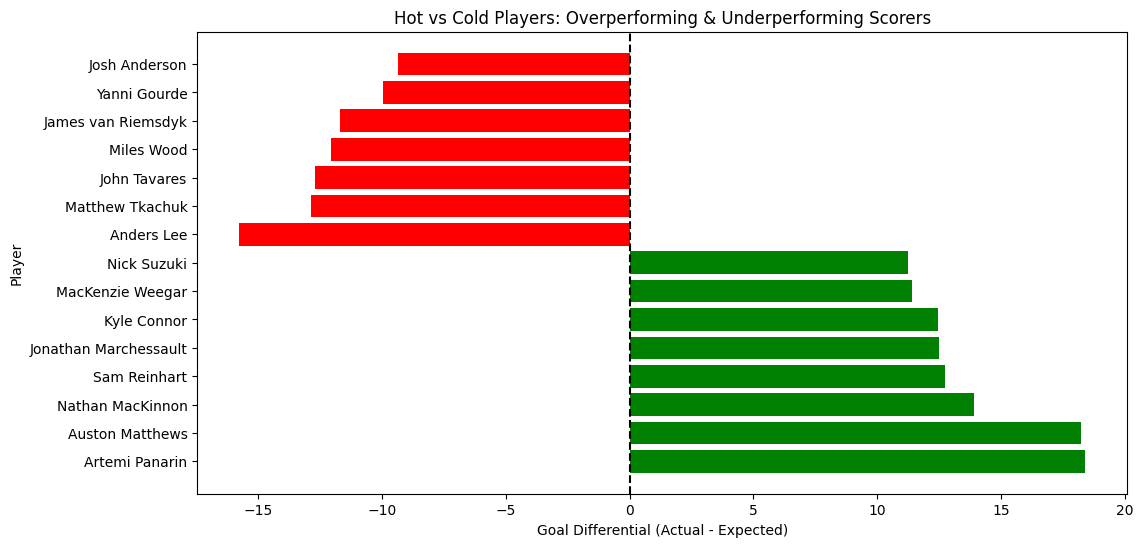

In [20]:
import matplotlib.pyplot as plt

# Combine hot & cold players for a visual comparison
top_players = pd.concat([hot_players, cold_players])

# Bar chart for goal over/underperformance
plt.figure(figsize=(12,6))
plt.barh(top_players['name'], top_players['goal_diff'], color=['green' if x > 0 else 'red' for x in top_players['goal_diff']])
plt.xlabel('Goal Differential (Actual - Expected)')
plt.ylabel('Player')
plt.title('Hot vs Cold Players: Overperforming & Underperforming Scorers')
plt.axvline(0, color='black', linestyle='--')  # Reference line at 0
plt.show()

## 📢 Key Takeaways
### 🔥 Overperformers:
- Players like **(Sam Reinhart, Kyle Connor, Nick Suzuki)** have significantly outperformed expectations.
- Their shooting efficiency is high, or they’re converting difficult chances.

### ❄️ Underperformers:
- Players like **(John Tavares, Josh Anderson, Anders Lee)** are struggling to finish.
- Low shooting percentage or bad luck might be factors.

This analysis provides insight into **which NHL players are over/underperforming in goal scoring** based on their expected goals (xG).
